# Cytoscape Ecosystem

Cytoscape is a well-known bioinformatics tool for displaying and exploring biological networks. The Cytoscape Ecosytem extends beyond the desktop software to include web apps (like cytoscape.js), community-contributed collections of networks (NDEx) and apps (AppStore), and the CyREST programmatic interface. Programmatic access and interactive display via R, Python and JS enable a braod range of applications in network anlaysis and visualization, leveraging the Cytoscape Ecosystem.

# The ndex2 python package

The ndex2 package provides a convenient wrapper around the NDEx server API. NDEx networks are transfered in the CX (Cytoscape Exchange) format and ndex2 includes the NiceCX Python object to simplify the use of CX data. 

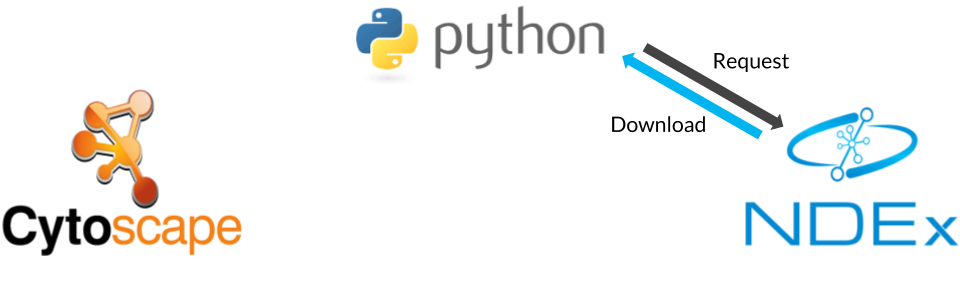

NiceCX does not provide common network manipulation functionality. For that, it is better to cast the data into forms such as networkx or igraph.

The Sphinx documentation for the ndex2 package is at https://ndex2.readthedocs.io/en/latest/.

Additional documentation and examples, including Jupyter Notebooks are available in the ndex2 GitHub repo: https://github.com/ndexbio/ndex2-client.

# Installation

The NDEx2 Python Client module can be installed from the Python Package Index (PyPI) repository using PIP:
```
pip install ndex2
```

If you already have an older version of the ndex2 module installed, you can use this command instead:
```
pip install --upgrade ndex2
```

In [1]:
# Import ndex2
import ndex2

# PART I

## Load Network from NDEx

We will import a network from NDEx into the python environment. Networks are provided a Universal Unique ID (UUID) by NDEx that can be used to reliably reference a particular network.

ndex2.create_nice_cx_from_server makes the request to the specified NDEx server URL with the UUID of the network. The server returns the network in CX format which is used to create a NiceCX object.

In [2]:
# Load a network from NDEx
SERVER = 'ndexbio.org'
NETWORK_UUID = 'b1e9a489-bbe7-11ea-aaef-0ac135e8bacf'

nice_cx_network = ndex2.create_nice_cx_from_server(SERVER, uuid=NETWORK_UUID)

## Copy Visual Style

One of the easiest ways to apply a visual style to a network is to copy that style from another network. This lets you work on the style of your network in Cytoscape using the interactive style editor, then save the network to NDEx for future use as a template.

The NiceCX class provides a special method for this common operation, both downloading the template and copying the style to the target network.

In [3]:
# Copy the style from a network in NDEx
STYLE_NETWORK_UUID = 'b1c1aa27-bbe7-11ea-aaef-0ac135e8bacf'

nice_cx_network.apply_template(SERVER, STYLE_NETWORK_UUID)

## Apply Layout

In the python environment, we will generate a NetworkX object using the NiceCX to_networkx method and then use the NetworkX spiral_layout method to assign positions to the nodes.

The result of the layout operation is a Python dictionary of positions keyed by nodes. We can show the network with that layout using the NetworkX draw method, passing in the positions.

To set the layout of the NiceCX network, we need to transform the NetworkX positions to a CX cartesianLayout aspect.

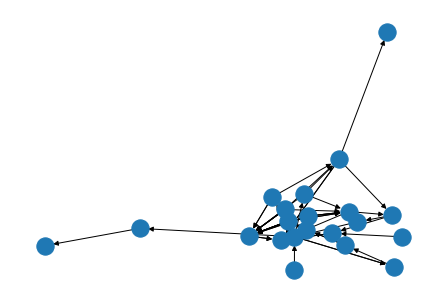

In [4]:
import networkx as nx

# Convert the network to a NetworkX network
networkx_network = nice_cx_network.to_networkx(mode='default')

# Make and view layout
pos = nx.drawing.layout.spring_layout(networkx_network, scale=1000)
nx.draw(networkx_network, pos)

# Transfer layout back to original network
new_cartesian_layout = []
for node_id, coordinates in pos.items():
    new_cartesian_layout.append({
        'node': node_id,
        'x': coordinates[0],
        'y': coordinates[1]
    })
nice_cx_network.set_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT, new_cartesian_layout)

## Save Network to NDEx

NiceCX networks have a convenient one-step upload method. There is also an "update_to" method to update an existing network instead of creating a new one.

In [5]:
# Set the name of the network
nice_cx_network.set_name(nice_cx_network.get_name() + ' (ndex2)')

# Get NDEx credentials
USERNAME = input('Username: ')
PASSWORD = input('Password: ')

# Save the network to NDEx
nice_cx_network.upload_to(SERVER, USERNAME, PASSWORD)

Username: ismbdemo
Password: ismbdemo2020
Generating CX


'http://public.ndexbio.org/v2/network/7bcdccdc-c2e7-11ea-aaef-0ac135e8bacf'

# PART II

## Load PPI Network

Tabular data can be read in as a dataframe and then loaded as a NiceCX network

Using ndex2, you can specify what each column of the input data contains: 

* source nodes, 
* target nodes, 
* source node attributes, 
* target node attributes, 
* edge interactions, or 
* edge attributes. 

By default, a column named "source" becomes the source node column, "target" becomes the target node column, "interaction" becomes the edge interactions column, and all other columns become edge attributes.

**Note:** If this step doesn't work, check that you have [installed python certificates](https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org).

In [6]:
import pandas as pd
PPI_DATA_URL = 'https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/ap-ms-demo-data.csv'

# Import PPI data as a dataframe
ppi_data = pd.read_csv(PPI_DATA_URL, sep=',')
ppi_data

,Bait,Prey,UniProt,HEKScore,JurkatScore,AP-MS Score
0,GAG,THRAP3,Q9Y2W1,0.807,0.319,0.563
1,GAG,SEPSECS,Q9HD40,0.814,0.200,0.507
2,GAG,IVNS1ABP,Q9Y6Y0,0.753,0.260,0.506
3,GAG,DDX49,Q9Y6V7,0.824,0.000,0.412
4,GAG,PRMT1,Q99873,0.758,0.037,0.397
...,...,...,...,...,...,...
494,GP41,TOMM40,O96008,0.762,0.000,0.381
495,GP41,GLG1,Q92896,0.000,0.762,0.381
496,GP41,NGLY1,Q96IV0,0.000,0.756,0.378
497,GP41,SEC62,Q99442,0.000,0.751,0.376


In [7]:
# Load PPI network
ppi_network = ndex2.create_nice_cx_from_pandas(
    ppi_data,
    source_field='Bait',
    target_field='Prey',
    target_node_attr=['UniProt'],
    edge_attr=['HEKScore', 'JurkatScore', 'AP-MS Score']
)

# Set the network's name
ppi_network.set_name('AP-MS Demo Data (ndex2)')

0


## Load Expression Data

Now, the network can be annotated with expression data. ndex2 can be used to add additional data to a network in the form of attributes on nodes, edges, or the network as a whole. 

In [8]:
# Load expression data as a dataframe
EXPRESSION_DATA_URL = 'https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/annotation-data.csv'

expression_data = pd.read_csv(EXPRESSION_DATA_URL, sep=',')
expression_data

,P-value,FCAbsolute,Regulation,GeneSymbol
0,0.027029,2.006743,up,ZNF594
1,0.012443,2.644313,up,GRB10
2,0.007062,1.881797,up,MTHFD2
3,0.044250,3.439971,up,ATF3
4,0.031662,1.955409,up,PMAIP1
...,...,...,...,...
311,0.007729,2.957946,down,SLC2A5
312,0.009410,1.861381,down,NaN
313,0.019493,1.599525,down,NaN
314,0.001827,1.699154,down,INF2


Using ndex2, a network can be annotated by matching rows of the input data with the names of nodes in the network. Then, the set_node_attribute method can be used to give the node the attributes found in the matching row of the input data.

In this example, the column "GeneSymbol" matches the names of the nodes in our network.

In [9]:
# Annotate network's nodes with gene expression data
for node_id, node in ppi_network.get_nodes():
    data = expression_data.loc[expression_data['GeneSymbol'] == node['n']]
    if len(data) == 1:
        for column in data.columns:
            if column == 'GeneSymbol':
                continue
            if column == 'Regulation':
                data_type = 'string'
            else:
                data_type = 'double'
            
            ppi_network.set_node_attribute(node_id, column, data.iloc[0][column], type=data_type)  

## Save Network to NDEx

Again, we can save this network to NDEx, including the associated expression data.

In [10]:
# Save network to NDEx
ppi_network.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


'http://public.ndexbio.org/v2/network/7c986fde-c2e7-11ea-aaef-0ac135e8bacf'